# Sprint Challenge
## *Data Science Sprint 13*

After a sprint of Natural Language Processing, you've learned some cool new stuff: how to process text, how turn text into vectors, and how to model topics from documents. Apply your newly acquired skills to one of the most famous NLP datasets out there: [Yelp](https://www.yelp.com/dataset). As part of the job selection process, some of my friends have been asked to create analysis of this dataset, so I want to empower you to have a head start.  

The real dataset is massive (almost 8 gigs uncompressed). The data is sampled for you to something more manageable for the Sprint Challenge. You can analyze the full dataset as a stretch goal or after the sprint challenge.

## Challenge Objectives
Successfully complete all these objectives to earn full credit.

**Successful completion is defined as passing all the unit tests in each objective.**  

There are 8 total possible points in this sprint challenge.


There are more details on each objective further down in the notebook.*
* <a href="#p1">Part 1</a>: Write a function to tokenize the yelp reviews
* <a href="#p2">Part 2</a>: Create a vector representation of those tokens
* <a href="#p3">Part 3</a>: Use your tokens in a classification model on Yelp rating
* <a href="#p4">Part 4</a>: Estimate & Interpret a topic model of the Yelp reviews

____

# Before you submit your notebook you must first

1) Restart your notebook's Kernel

2) Run all cells sequentially, from top to bottom, so that cell numbers are sequential numbers (i.e. 1,2,3,4,5...)
- Easiest way to do this is to click on the **Cell** tab at the top of your notebook and select **Run All** from the drop down menu.

3) **Comment out the cell that generates a pyLDAvis visual in objective 4 (see instructions in that section).**
____

In [43]:
!python -m spacy download en_core_web_md

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 33.5/33.5 MB 11.6 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_md')
⚠ Restart to reload dependencies
If you are in a Jupyter or Colab notebook, you may need to restart Python in
order to load all the package's dependencies. You can do this by selecting the
'Restart kernel' or 'Restart runtime' option.


In [2]:
!pip install gensim

In [1]:
!pip install catboost

### Part 0: Import Necessary Packages
For this section, you will need to import:
- `spacy`
- `Pandas`
- `Seaborn`
- `Matplotlib`
- `NearestNeighbors`
- `Pipeline`
- `TfidfVectorizer`
- `KneighborsClassifier`
- `GridSearchCV`
- `corpora`
- `LdaModel`
- `gensim`
- `re`

> **Note: This assignment is optimized to work with these specific packages. You can use import different packages, but note that this may affect how CodeGrade works, and may cause CodeGrade to fail.**

In [4]:
!pip install pyLDAvis

In [5]:
import re
import string

from sklearn.feature_extraction.text import CountVectorizer,TfidfVectorizer
from sklearn.neighbors import NearestNeighbors

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier
import xgboost as xgb
from xgboost import XGBClassifier
from sklearn.pipeline import Pipeline
import gensim
from gensim import corpora
from gensim.models import LdaModel
from gensim.models.coherencemodel import CoherenceModel
import pyLDAvis.gensim_models as gensimvis
import pyLDAvis
import seaborn as sns
from sklearn.decomposition import TruncatedSVD

from bs4 import BeautifulSoup

%matplotlib inline

import spacy
nlp = spacy.load("en_core_web_md", enable=['parse', 'tagger'])

/usr/local/lib/python3.11/dist-packages/spacy/cli/_util.py:23: DeprecationWarning: Importing 'parser.split_arg_string' is deprecated, it will only be available in 'shell_completion' in Click 9.0.
  from click.parser import split_arg_string
/usr/local/lib/python3.11/dist-packages/weasel/util/config.py:8: DeprecationWarning: Importing 'parser.split_arg_string' is deprecated, it will only be available in 'shell_completion' in Click 9.0.
  from click.parser import split_arg_string


In [6]:
# Visible Testing
assert pd.__package__ == 'pandas'




### Part 0: Import Data

In [7]:
import requests

# Load reviews from URL
data_url = 'https://raw.githubusercontent.com/bloominstituteoftechnology/data-science-practice-datasets/main/unit_4/unit1_nlp/review_sample.json'

# Import data into a DataFrame named df
# YOUR CODE HERE
# response = requests.get(data_url)
# df = pd.read_json(response.text, lines=True)

# you can do this directly:
df = pd.read_json(data_url, lines=True)

In [8]:
df.head()

,business_id,cool,date,funny,review_id,stars,text,useful,user_id
0,nDuEqIyRc8YKS1q1fX0CZg,1,2015-03-31 16:50:30,0,eZs2tpEJtXPwawvHnHZIgQ,1,"BEWARE!!! FAKE, FAKE, FAKE....We also own a sm...",10,n1LM36qNg4rqGXIcvVXv8w
1,eMYeEapscbKNqUDCx705hg,0,2015-12-16 05:31:03,0,DoQDWJsNbU0KL1O29l_Xug,4,Came here for lunch Togo. Service was quick. S...,0,5CgjjDAic2-FAvCtiHpytA
2,6Q7-wkCPc1KF75jZLOTcMw,1,2010-06-20 19:14:48,1,DDOdGU7zh56yQHmUnL1idQ,3,I've been to Vegas dozens of times and had nev...,2,BdV-cf3LScmb8kZ7iiBcMA
3,k3zrItO4l9hwfLRwHBDc9w,3,2010-07-13 00:33:45,4,LfTMUWnfGFMOfOIyJcwLVA,1,We went here on a night where they closed off ...,5,cZZnBqh4gAEy4CdNvJailQ
4,6hpfRwGlOzbNv7k5eP9rsQ,1,2018-06-30 02:30:01,0,zJSUdI7bJ8PNJAg4lnl_Gg,4,"3.5 to 4 stars\n\nNot bad for the price, $12.9...",5,n9QO4ClYAS7h9fpQwa5bhA


In [9]:
# Visible Testing
assert isinstance(df, pd.DataFrame), 'df is not a DataFrame. Did you import the data into df?'
assert df.shape[0] == 10000, 'DataFrame df has the wrong number of rows.'

## Part 1: Tokenize Function
<a id="#p1"></a>

Complete the function `tokenize`. Your function should
- Accept one document at a time
- Return a list of tokens

You are free to use any method you have learned this week.

**TO PASS CODEGRADE RUNTIME:**
- Do not run your tokenize function more than one time in your notebook! It is not needed until Part 4!

In [10]:
# Optional: Consider using spaCy in your function. The spaCy library can be imported by running this cell.
# A pre-trained model (en_core_web_sm) has been made available to you in the CodeGrade container.
# If you DON'T need use the en_core_web_sm model, you can comment it out below.

nlp = spacy.load('en_core_web_sm')

In [11]:
# YOUR CODE HERE
def tokenize(doc):
    """
    Uses spaCy language model to tokenize doc.
    Token filters are used to exclude low quality tokens.

    Note
    ----
    Remember to check out the spacy docs to see which token flags are available for you to use
    https://spacy.io/api/token

    Input
    ----------
    doc: string
        raw dco document that needs to be tokenized

    Returns
    -------
    tokens: list of strings
    """
    doc = nlp(doc)

    tokens = []

    for token in doc:
      if(token.is_stop !=True) and (token.is_punct !=True) and (token.is_space !=True) and (token.is_quote !=True):
        tokens.append(token.lemma_)

    return tokens

In [12]:
'''Testing'''
assert isinstance(tokenize(df.sample(n=1)["text"].iloc[0]), list), "Make sure your tokenizer function accepts a single document and returns a list of tokens!"

## Part 2: Vector Representation
<a id="#p2"></a>
1. Create a vector representation of the reviews (i.e. create a doc-term matrix).
    * Name that doc-term matrix `dtm`

In [13]:
# ## Instantiate tfidf TfidfVectorizer
# tfidf = TfidfVectorizer(tokenizer=tokenize, stop_words="english")
# ## Fit the tfidfVectorizer to the clean_text
# tfidf = tfidf.fit(df.text)
# ## Transform the clean_text to get the document term matrix
# dtm = tfidf.transform(df.text).toarray()

In [14]:
#save time I'm going to do the whole thing in TfidfVectorizer
# ## Instantiate tfidf TfidfVectorizer
tfidf = TfidfVectorizer(stop_words="english")
# ## Fit the tfidfVectorizer to the clean_text
# tfidf = tfidf.fit(df.text)
# ## Transform the clean_text to get the document term matrix
dtm = tfidf.fit_transform(df.text).toarray()

In [15]:
%%time
# YOUR CODE HERE
#dtm_tfidf = TfidfVectorizer(tokenizer=tokenize).fit_transform(df["text"])

CPU times: user 3 µs, sys: 0 ns, total: 3 µs
Wall time: 5.48 µs



2. Write a fake review. Assign the text of the review to an object called `fake_review`.
3. Query the fake review for the 10 most similar reviews, print the text of the reviews.
    - Given the size of the dataset, use `NearestNeighbors` model for this. Name the model `nn`.

In [16]:
fake_review = "Urgently searching for a data scientist with deep undersanding in machine learning, predictive model, software engineering, deep learning, neural network and natural language processing. He or she must have certificate in any of the science related programs and this personal must have an experience of 2 years in data science and the knowledge of bayesian statistics is an added advantage."

In [17]:
# Create and fit a NearestNeighbors model named "nn"
# YOUR CODE HERE
top_n_neigh = 10
nn = NearestNeighbors(n_neighbors=10)
nn.fit(dtm)


NearestNeighbors(n_neighbors=10)

In [18]:
'''Testing.'''
assert nn.__module__ == 'sklearn.neighbors._unsupervised', ' nn is not a NearestNeighbors instance.'
assert nn.n_neighbors == 10, 'nn has the wrong value for n_neighbors'

In [19]:
# Create a fake review and find the 10 most similar reviews

# YOUR CODE HERE
fake_review2 = "Urgently searching for a data scientist with deep undersanding in machine learning, predictive model, software engineering, deep learning"

# Assuming 'n_ind' is defined from the NearestNeighbors search in a previous cell
# You need to run cell r9FSdd8nj0o7 to define n_ind first.
if 'n_ind' in locals():
    count = 0
    for most_sim_job_index in n_ind[:][0]:
        most_sim_job = df.text.iloc[most_sim_job_index]
        count += 1
        print("\n", count, "", most_sim_job)
#else:
    #print("Error: n_ind is not defined. Please run cell r9FSdd8nj0o7 first.")

In [20]:
distances, indexes = nn.kneighbors(tfidf.transform([fake_review2]), n_neighbors=10)

df.loc[indexes.flatten(),'text']

,text
2661,I was having trouble with my laptop it was slo...
7034,"There deep dish pizza is to die for, reasonabl..."
6318,We found this place on Yelp and came in. \nThe...
8638,I am updating my previous review to include th...
2096,"Deep fries calamari is great, gyro is avarage...."
6015,Great service and food. Salads are amazing dri...
5571,My daughter is very happy to be part of this p...
5221,I just moved to Phoenix and need a good groome...
5993,New location. Still learning their way around ...
2197,Guu originated from our friends on the West co...


In [21]:
# Visible Testing
assert isinstance(fake_review, str), "Did you write a review in the correct data type?"

## Part 3: Classification
<a id="#p3"></a>
Your goal in this section will be to predict `stars` from the review dataset.

1. Create a pipeline object with a sklearn `CountVectorizer` or `TfidfVector` and any sklearn classifier.
    - Use that pipeline to train a model to predict the `stars` feature (i.e. the labels).
    - Use that pipeline to predict a star rating for your fake review from Part 2.



2. Create a parameter dict including `one parameter for the vectorizer` and `one parameter for the model`.
    - Include 2 possible values for each parameter
        - **Keep the values for each parameter low. Extreme values will compromise runtime**
    - **Use `n_jobs` = 1**
    - Due to limited computational resources on CodeGrader `DO NOT INCLUDE ADDITIONAL PARAMETERS OR VALUES PLEASE.`
    
    
3. Train the entire pipeline with a GridSearch
    - Name your GridSearch object as `gs`

In [22]:
#vect = TfidfVectorizer(stop_words='english', max_features=500, ngram_range=(1,2), tokenizer=tokenize, lowercase=False)
vect = TfidfVectorizer(stop_words='english', max_features=500, ngram_range=(1,2), lowercase=True)
from sklearn.feature_extraction.text import CountVectorizer

In [23]:
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()

y = le.fit_transform(df.loc[:,'stars'])

# y_train = df['stars']
# X_train = df['text']
# y_test = df['stars']
# X_test = df['text']
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

X_train, X_test, y_train, y_test = train_test_split(df.loc[:,'text'], y, random_state=42, stratify=y)

In [24]:
pipe = Pipeline([
    ('vect', vect),
    ('clf', XGBClassifier(n_jobs=-1,objective='multi:softmax', num_class=len(np.unique(y))))
])

In [25]:
parameters = {
    #'vect__max_df': ([0.75, 1.0]),  # Less restrictive max_df values
    #'vect__min_df': ([0.01, 0.05]), # Add min_df
    'clf__n_estimators': ([100, 200]), # More appropriate n_estimators
    'clf__max_depth': ([3, 5]), # Keep max_depth
    #'clf__learning_rate': ([0.1, 0.01]), # Keep learning_rate
    # Removed clf__num_leaves and clf__min_data_in_leaf as they are not for XGBoost
}

In [26]:
# # COMPLETE CODE HERE
# def star_rating_numeric(rating_string):
#   return float(rating_string.split()[0])
#   df['star_rating_numeric'] = df['star_rating'].str.extract(r'(\d+\.?\d*)').astype(float)

# #df['star_rating'] = df['full_review_text'].apply[star_rating_numeric]

# df.head()

In [27]:
#this works:
pipe.fit(X_train,y_train)

Pipeline(steps=[('vect',
                 TfidfVectorizer(max_features=500, ngram_range=(1, 2),
                                 stop_words='english')),
                ('clf',
                 XGBClassifier(base_score=None, booster=None, callbacks=None,
                               colsample_bylevel=None, colsample_bynode=None,
                               colsample_bytree=None, device=None,
                               early_stopping_rounds=None,
                               enable_categorical=False, eval_metric=None,
                               feature_types=None, gamma=None, grow_policy=None,
                               importance_type=None,
                               interaction_constraints=None, learning_rate=None,
                               max_bin=None, max_cat_threshold=None,
                               max_cat_to_onehot=None, max_delta_step=None,
                               max_depth=None, max_leaves=None,
                               min_child_weight=None, missing=nan,
                               monotone_constraints=None, multi_strategy=None,
                               n_estimators=None, n_jobs=-1, num_class=5,
                               num_parallel_tree=None, ...))])

In [28]:
#and when we put the pipe in the grid search, it works also:
gs = GridSearchCV(pipe, parameters, cv=5, n_jobs=-1, error_score='raise')
gs.fit(X_train, y_train)

GridSearchCV(cv=5, error_score='raise',
             estimator=Pipeline(steps=[('vect',
                                        TfidfVectorizer(max_features=500,
                                                        ngram_range=(1, 2),
                                                        stop_words='english')),
                                       ('clf',
                                        XGBClassifier(base_score=None,
                                                      booster=None,
                                                      callbacks=None,
                                                      colsample_bylevel=None,
                                                      colsample_bynode=None,
                                                      colsample_bytree=None,
                                                      device=None,
                                                      early_stopping_rounds=None,
                                                      enable_categorical=False,
                                                      eval_met...
                                                      learning_rate=None,
                                                      max_bin=None,
                                                      max_cat_threshold=None,
                                                      max_cat_to_onehot=None,
                                                      max_delta_step=None,
                                                      max_depth=None,
                                                      max_leaves=None,
                                                      min_child_weight=None,
                                                      missing=nan,
                                                      monotone_constraints=None,
                                                      multi_strategy=None,
                                                      n_estimators=None,
                                                      n_jobs=-1, num_class=5,
                                                      num_parallel_tree=None, ...))]),
             n_jobs=-1,
             param_grid={'clf__max_depth': [3, 5],
                         'clf__n_estimators': [100, 200]})

In [29]:
gs.best_params_

{'clf__max_depth': 5, 'clf__n_estimators': 100}

In [30]:
# you can pull out the best estimator (model) from the grid search. You may want to save this to a picklefile or something
best_model = gs.best_estimator_
best_predictions = best_model.predict(X_test)

In [31]:
print(classification_report(best_predictions, y_test))

              precision    recall  f1-score   support

           0       0.70      0.68      0.69       387
           1       0.12      0.27      0.16        82
           2       0.18      0.38      0.24       128
           3       0.36      0.40      0.38       496
           4       0.83      0.66      0.74      1407

    accuracy                           0.58      2500
   macro avg       0.44      0.48      0.44      2500
weighted avg       0.66      0.58      0.61      2500



In [32]:
print(confusion_matrix(best_predictions, y_test))

[[262  63  27  12  23]
 [ 20  22  23  12   5]
 [ 15  27  49  21  16]
 [ 18  40 100 196 142]
 [ 59  38  76 305 929]]


In [33]:
print(accuracy_score(best_predictions, y_test))

0.5832


In [34]:
prediction = gs.predict([fake_review])[0]
print(f"The predicted star rating for the fake review is: {prediction}")

The predicted star rating for the fake review is: 4


In [35]:
# Visible Testing
prediction = gs.predict(["This is your prediction statement."])[0]
assert prediction in df.stars.values, 'You gs object should be able to accept raw text within a list. Did you include a vectorizer in your pipeline?'

## Part 4: Topic Modeling

Let's find out what those yelp reviews are saying! :D

1. Estimate a LDA topic model of the review text
    - Set num_topics to `5`
    - Name your LDA model `lda`
2. Create 1-2 visualizations of the results
    - You can use the most important 3 words of a topic in relevant visualizations.
3. In markdown, write 1-2 paragraphs of analysis on the results of your topic model

When you instantiate your LDA model, it should look like this:

```python
lda = LdaModel(corpus=corpus,
               id2word=id2word,
               random_state=723812,
               num_topics = num_topics,
               passes=1
              )

```

__*Note*__: You can pass the DataFrame column of text reviews to gensim. You do not have to use a generator.

## Note about  pyLDAvis

**pyLDAvis** is the Topic modeling package that we used in class to visualize the topics that LDA generates for us.

You are welcomed to use pyLDAvis if you'd like for your visualization. However, **you MUST comment out the code that imports the package and the cell that generates the visualization before you submit your notebook to CodeGrade.**

Although you should leave the print out of the visualization for graders to see (i.e. comment out the cell after you run it to create the viz).

### 1. Estimate a LDA topic model of the review text

* Use the `tokenize` function you created earlier to create tokens.
* Create an `id2word` object.
> Hint: Use `corpora.Dictionary`
* Create a `corpus` object.
> Hint: Use `id2word.doc2bow`
* Instantiate an `lda` model.

>> Remember to read the LDA docs for more information on the various class attributes and methods available to you in the LDA model: https://radimrehurek.com/gensim/models/ldamodel.html

In [36]:
# Do not change this value
num_topics = 5

In [37]:
# YOUR CODE HERE
# Tokenize the text
tokenized_text = [tokenize(doc) for doc in df['text']]

# Create a dictionary from the tokenized text
id2word = corpora.Dictionary(tokenized_text)

# Create a corpus (bag-of-words representation)
corpus = [id2word.doc2bow(tokens) for tokens in tokenized_text]

# Do not change this value
num_topics = 5

lda_model = gensim.models.ldamodel.LdaModel(
    corpus=corpus,
    id2word=id2word,
    num_topics=num_topics,
    random_state=723812, # Added random_state as requested in markdown cell
    passes=1,
    # per_word_topics=True # Removed this as it's not needed for the task and might increase runtime
)

In [62]:
%%time
# Corrected code to create a new LDA model with per_word_topics=True
lda = gensim.models.ldamodel.LdaModel(corpus=corpus, id2word=id2word, num_topics= 5, chunksize= 100, passes= 1, per_word_topics=True)

CPU times: user 6.22 s, sys: 32.9 ms, total: 6.25 s
Wall time: 6.3 s


#### Testing

In [63]:
# Visible Testing

assert lda.get_topics().shape[0] == 5, 'Did your model complete its training? Did you set num_topics to 5?'

#### 2. Create 2 visualizations of the results:
1. Create a visualization using pyLDAvis. Run the cell, then comment out your code before submission, leaving the visualization in the cell.

2. Create a visualization using the matplotlib library and utilizing the subplots function. Assign this visualization to a variable called `visual_plot`.


In [66]:
# Cell for pyLDAvis visualization
# YOUR CODE HERE
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim_models.prepare(lda_model, corpus, id2word)
vis

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
1      0.167795  0.161336       1        1  35.626863
4      0.170056  0.002781       2        1  32.982332
2      0.118680 -0.239200       3        1  21.674741
0     -0.126015  0.125476       4        1   6.143735
3     -0.330517 -0.050393       5        1   3.572328, topic_info=               Term         Freq        Total Category  logprob  loglift
144            food  4784.000000  4784.000000  Default  30.0000  30.0000
373           order  3388.000000  3388.000000  Default  29.0000  29.0000
493            tell  1564.000000  1564.000000  Default  28.0000  28.0000
34              say  1579.000000  1579.000000  Default  27.0000  27.0000
1205           taco   501.000000   501.000000  Default  26.0000  26.0000
...             ...          ...          ...      ...      ...      ...
3685        Madison    52.663726    53.524498   Topic5  -5.8121   3.3157
1229       straight    66.670284    68.244103   Topic5  -5.5763   3.3086
1579            gym   108.123381   114.929753   Topic5  -5.0928   3.2709
340             cut   205.644181   452.418869   Topic5  -4.4499   2.5435
728   unfortunately    56.372650   226.703007   Topic5  -5.7441   1.9403

[311 rows x 6 columns], token_table=      Topic      Freq     Term
term                          
0         1  0.276975        $
0         2  0.422554        $
0         3  0.283232        $
0         4  0.017102        $
0         5  0.000417        $
...     ...       ...      ...
320       3  0.637385     work
320       4  0.023977     work
320       5  0.001332     work
1603      5  0.982837  workout
3725      5  0.978372        à

[540 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[2, 5, 3, 1, 4])

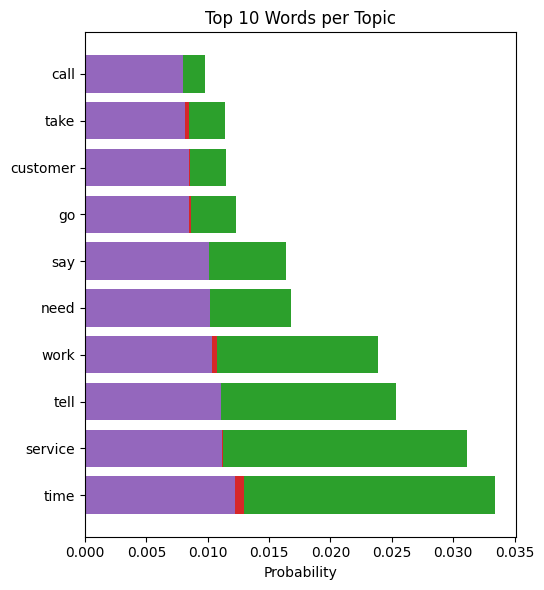

In [56]:
# Cell for matplotlib visualzation
# YOUR CODE
visual_plot = plt.figure(figsize=(10, 6))
plt.subplot(1, 2, 1)
for topic_idx, topic in enumerate(lda_model.get_topics()):
    top_words_idx = topic.argsort()[:-11:-1]
    top_words = [id2word[i] for i in top_words_idx]
    plt.barh(np.arange(10), topic[top_words_idx])
    plt.yticks(np.arange(10), top_words)
    plt.xlabel('Probability')
    plt.title('Top 10 Words per Topic')
    plt.tight_layout()
plt.show()


In [57]:
# Visible testing
assert visual_plot is not None, "Variable 'visual_plot' is not created."

In [54]:
# Get the best estimator from the fitted GridSearchCV
best_pipeline = gs.best_estimator_

# Extract the vectorizer and classifier from the best pipeline
best_vectorizer = best_pipeline.named_steps['vect']
best_classifier = best_pipeline.named_steps['clf']

# Manually transform the fake_review using the best vectorizer
# The vectorizer's transform method expects an iterable of strings
fake_review_vectorized_manual = best_vectorizer.transform([fake_review])

# Make a prediction using the best classifier and the manually vectorized data
prediction_manual = best_classifier.predict(fake_review_vectorized_manual)

print(f"The predicted star rating for the fake review (manual prediction) is: {prediction_manual[0]}")

The predicted star rating for the fake review (manual prediction) is: 4


In [55]:
# Define features (X) and labels (y)
X = df['text']
y = df['stars'] - 1 # Adjust target variable to be zero-indexed

# Use the pipeline defined in cell xXsJV4UD6Oml
model = pipe

# Create and fit the GridSearchCV object
# Use n_jobs=1 as requested in the markdown cell HzmpYf6-j0o9
# Use the parameters defined in cell ZUlx_rIXc0N4
gs = GridSearchCV(model, parameters, cv=5, n_jobs=1)
gs.fit(X, y)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('vect',
                                        TfidfVectorizer(max_features=500,
                                                        ngram_range=(1, 2),
                                                        stop_words='english')),
                                       ('clf',
                                        XGBClassifier(base_score=None,
                                                      booster=None,
                                                      callbacks=None,
                                                      colsample_bylevel=None,
                                                      colsample_bynode=None,
                                                      colsample_bytree=None,
                                                      device=None,
                                                      early_stopping_rounds=None,
                                                      enable_categorical=False,
                                                      eval_metric=None,
                                                      feature_typ...
                                                      learning_rate=None,
                                                      max_bin=None,
                                                      max_cat_threshold=None,
                                                      max_cat_to_onehot=None,
                                                      max_delta_step=None,
                                                      max_depth=None,
                                                      max_leaves=None,
                                                      min_child_weight=None,
                                                      missing=nan,
                                                      monotone_constraints=None,
                                                      multi_strategy=None,
                                                      n_estimators=None,
                                                      n_jobs=-1, num_class=5,
                                                      num_parallel_tree=None, ...))]),
             n_jobs=1,
             param_grid={'clf__max_depth': [3, 5],
                         'clf__n_estimators': [100, 200]})